<a href="https://www.kaggle.com/code/ahmedhassounaa/teeth-classification-project?scriptVersionId=193482678" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://www.kaggle.com/code/ahmedhassounaa/teeth-classification-project?scriptVersionId=193482678" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Data Acquisition and Setup

In this section, we begin by downloading the dataset, setting up the environment, and preparing the data for further processing.

### 1. Downloading the Dataset
The dataset is downloaded from a shared Google Drive link using the `gdown` library. This dataset contains images of various types of teeth, which will be used for training and testing the classification model.


In [54]:
!pip install gdown
import gdown
!gdown --id 1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY


/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY
From (redirected): https://drive.google.com/uc?id=1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY&confirm=t&uuid=e42a9729-e7db-4096-835f-0f521f3bf413
To: /kaggle/working/Teeth DataSet.zip
100%|███████████████████████████████████████| 49.1M/49.1M [00:00<00:00, 179MB/s]



## Project Setup: Data Preparation

First, the dataset is downloaded from Google Drive using the `gdown` tool. After the download is complete, several essential libraries are imported, including PyTorch, torchvision, and PIL, which are necessary for handling images and performing transformations. The dataset, provided in a `.zip` file, is then extracted into the working directory using Python's `zipfile` module.



In [55]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import os
from PIL import Image
import matplotlib.pyplot as plt
import zipfile
with zipfile.ZipFile('/kaggle/working/Teeth DataSet.zip', 'r') as zip_ref:
    zip_ref.extractall()

!rm -rf /kaggle/working/Teeth_Dataset/Testing/outputs
!rm -rf /kaggle/working/Teeth_Dataset/Testing/output
!rm -rf /kaggle/working/Teeth_Dataset/Testing/out
!rm -rf /kaggle/working/Teeth_Dataset/Testing/output_image.jpg
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Custom Dataset Class: `TeethDataset`

The `TeethDataset` class is a custom PyTorch dataset designed to load and preprocess teeth images stored in a directory structure where subdirectories represent class labels.

- **Initialization (`__init__`)**: 
  - Takes a directory path and an optional transformation function.
  - Maps each label (subdirectory) to an integer and stores image paths and their corresponding labels.

- **Length (`__len__`)**: 
  - Returns the total number of images in the dataset.

- **Get Item (`__getitem__`)**: 
  - Retrieves an image and its label by index.
  - Applies transformations if provided.


In [56]:
from torchvision import transforms
import os
from PIL import Image
from torch.utils.data import Dataset

class TeethDataset(Dataset):
    def __init__(self, directory, transform=None):
        """
        Args:
            directory (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.directory = directory
        self.transform = transform
        self.images = []
        self.labels = []
        self.label_dict = {}  # Dictionary to map labels to indices
        current_label_index = 0

        for label in sorted(os.listdir(directory)):
            label_path = os.path.join(directory, label)
            if os.path.isdir(label_path):  # Make sure it's a directory
                if label not in self.label_dict:
                    self.label_dict[label] = current_label_index
                    current_label_index += 1
                
                for img in sorted(os.listdir(label_path)):
                    self.images.append(os.path.join(label_path, img))
                    self.labels.append(self.label_dict[label])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        image = Image.open(img_name).convert('RGB')
        label = self.labels[idx]  # Directly use the mapped integer label

        if self.transform:
            image = self.transform(image)

        return image, label


## Image Transformations

A series of image transformations are applied to prepare the teeth images for training. These transformations are composed using `transforms.Compose` and include:

- **Resize**: Resizes images to a fixed size of 150x150 pixels.  
  *Reason*: Ensures a consistent input size for the neural network, which is necessary for batch processing and compatible with pre-trained models.

- **Random Horizontal Flip**: Randomly flips images horizontally.  
  *Reason*: Augments the dataset by creating mirror images, which helps the model generalize better by learning invariant features, reducing overfitting.

- **ToTensor**: Converts the image to a PyTorch tensor and scales pixel values to the range [0, 1].  
  *Reason*: Converts images into a format suitable for PyTorch, allowing for efficient processing and enabling the use of GPU acceleration.

- **Normalize**: Normalizes the image tensor using the specified mean and standard deviation.  
  *Reason*: Standardizes the input distribution, which accelerates convergence during training and is necessary when using pre-trained models that expect images normalized in this manner.


In [57]:
transformations  = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Data Loading

After defining the dataset and transformations, we load the training and validation data using the `DataLoader` class from PyTorch. This allows for efficient data loading and batching during model training and validation.

- **Training Dataset and DataLoader**:
  - `train_dataset`: Created using the `TeethDataset` class, pointing to the directory containing the training images. The transformations defined earlier are applied to each image.
  - `train_loader`: Utilizes the `DataLoader` class to load data from `train_dataset` in batches of 32 images. The `shuffle=True` parameter ensures that the data is shuffled at the beginning of each epoch, which helps in reducing model overfitting by providing varied data batches.

- **Validation Dataset and DataLoader**:
  - `validation_dataset`: Similarly, the validation dataset is created using the `TeethDataset` class, pointing to the directory containing validation images. The same transformations are applied to ensure consistency between training and validation data.
  - `validation_loader`: Loads data from `validation_dataset` in batches of 32 images. Here, `shuffle=False` ensures that the validation data is processed in a consistent order, which is crucial for accurate model evaluation.


In [58]:
train_dataset = TeethDataset('/kaggle/working/Teeth_Dataset/Training', transform=transformations)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

validation_dataset = TeethDataset('/kaggle/working/Teeth_Dataset/Validation', transform=transformations)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False, num_workers=2)

testing_dataset = TeethDataset('/kaggle/working/Teeth_Dataset/Testing', transform=transformations)
testing_loader = DataLoader(testing_dataset, batch_size=64, shuffle=False, num_workers=2)

## Inspecting a Batch of Training Data

This step involves checking the integrity of the data loading and transformation process by extracting and visualizing a batch of images and their corresponding labels:

- **Batch Extraction**: 
  - A single batch of images (`train_features`) and labels (`train_labels`) is retrieved from the `train_loader` using `next(iter(train_loader))`.
  - This allows us to inspect a portion of the dataset as it would be fed into the model.

- **Batch Shape Verification**:
  - The shapes of the feature and label batches are printed to ensure that the data is correctly batched. This verifies that the data is in the expected format and ready for training.

- **Image Selection and Adjustment**:
  - One image from the batch is selected (`train_features[5]`) for visualization.
  - The image tensor is permuted to change the dimensions from `[C, H, W]` (Channel, Height, Width) to `[H, W, C]` for compatibility with `matplotlib`.

- **Normalization and Visualization**:
  - The image is normalized to the [0, 1] range for display purposes.
  - The selected image is then displayed using `plt.imshow()`, and the associated label is printed to confirm the class.


Feature batch shape: torch.Size([64, 3, 150, 150])
Labels batch shape: torch.Size([64])


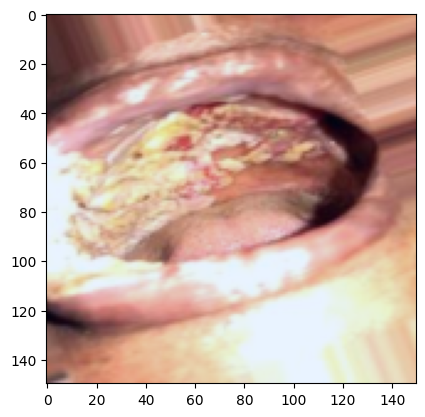

Label: 3


In [59]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# Get the first image from the batch and adjust its dimensions
img = train_features[5].permute(1, 2, 0)

# Normalize the pixel values to [0, 1] for displaying
img = img - img.min()
img = img / img.max()

label = train_labels[5]

# Display the image
plt.imshow(img)
plt.show()
print(f"Label: {label}")

## Model Definition: AdvancedTeethNet

The `AdvancedTeethNet` class defines a convolutional neural network (CNN) tailored for teeth image classification. This enhanced network architecture comprises additional layers and mechanisms to improve learning and generalization:

### Convolutional Layers:
- **conv1**: Applies a convolution with 32 filters of size 3x3, using padding to preserve spatial dimensions.
- **conv2**: Continues with 64 filters of size 3x3.
- **conv3**: Further increases depth with 128 filters of size 3x3.
- **conv4**: Extends convolution depth with 256 filters of size 3x3.
- Each convolutional layer is followed by a batch normalization layer (e.g., `bn1`, `bn2`, `bn3`, `bn4`) to stabilize learning by normalizing the activations.

### Pooling:
- **pool**: Utilizes max pooling with a 2x2 window to progressively reduce spatial dimensions after each convolutional block.

### Activation Function:
- **ReLU**: The ReLU activation function is applied after each batch normalization layer to introduce non-linearity, facilitating complex pattern learning in images.

### Fully Connected Layers:
- **fc1**: A linear layer that connects the flattened output of the final pooling layer to a 1024-dimensional hidden layer, incorporating dropout with a 50% rate to prevent overfitting.
- **fc2**: Further processes the features down to a 128-dimensional layer, again followed by dropout.
- **fc3**: Outputs the final classification scores for 7 classes.

### Dropout:
- Introduced at two points in the network (after `fc1` and `fc2`) to reduce overfitting by randomly omitting subsets of features during training.

### Forward Pass:
- The `forward` method defines the data flow through the network: sequential application of convolutions, batch normalizations, activation functions, poolings, and fully connected layers, with dropout applied post-activation in the dense layers.


In [60]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
class TeethNet(nn.Module):
    def __init__(self):
        super(TeethNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(128 * 18 * 18, 512)
        self.fc2 = nn.Linear(512, 7)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
            
        x = x.view(-1, 128 * 18 * 18)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = TeethNet()
model.to(device)

TeethNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=41472, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=7, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)

## Training the Model

The following code sets up and trains the `TeethNet` model using stochastic gradient descent (SGD) and cross-entropy loss.

- **Loss Function**:
  - `criterion`: Uses `nn.CrossEntropyLoss()` to compute the loss between the model's predictions and the true labels. This is suitable for classification tasks.

- **Optimizer**:
  - `optimizer`: An instance of `optim.SGD` is used to update the model's parameters. It includes:
    - **Learning Rate** (`lr`): Set to 0.01.
    - **Momentum**: Set to 0.9, which helps accelerate convergence and smoothens updates.

- **Training Process**:
  - **Number of Epochs**: The model is trained for 10 epochs.
  - **Epoch Loop**: Iterates over the dataset multiple times.
  - **Mini-batch Loop**: For each mini-batch in the training data:
    - **Data Unpacking**: Extracts inputs and labels.
    - **Gradient Zeroing**: Resets the gradients of model parameters.
    - **Forward Pass**: Computes the model's predictions.
    - **Loss Calculation**: Evaluates the loss using the criterion.
    - **Backward Pass**: Computes gradients with respect to the loss.
    - **Parameter Update**: Updates model parameters using the optimizer.
    - **Loss Tracking**: Accumulates and prints the average loss every 100 mini-batches.


In [61]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


# Number of epochs to train the model
num_epochs = 30

for epoch in range(num_epochs):  # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # Unpack data
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Perform a single optimization step (parameter update)
        optimizer.step()

        # Update running training loss
        running_loss += loss.item()

        # Print statistics every 100 mini-batches
        if i % 20==19:    # print every 100 mini-batches
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Average Loss: {running_loss / 100:.4f}')
            running_loss = 0.0

print('Finished Training')

Epoch 1, Batch 20, Average Loss: 0.3833
Epoch 1, Batch 40, Average Loss: 0.3600
Epoch 2, Batch 20, Average Loss: 0.3494
Epoch 2, Batch 40, Average Loss: 0.3317
Epoch 3, Batch 20, Average Loss: 0.3065
Epoch 3, Batch 40, Average Loss: 0.2920
Epoch 4, Batch 20, Average Loss: 0.2740
Epoch 4, Batch 40, Average Loss: 0.2646
Epoch 5, Batch 20, Average Loss: 0.2341
Epoch 5, Batch 40, Average Loss: 0.2120
Epoch 6, Batch 20, Average Loss: 0.1731
Epoch 6, Batch 40, Average Loss: 0.1683
Epoch 7, Batch 20, Average Loss: 0.1584
Epoch 7, Batch 40, Average Loss: 0.1391
Epoch 8, Batch 20, Average Loss: 0.1092
Epoch 8, Batch 40, Average Loss: 0.1069
Epoch 9, Batch 20, Average Loss: 0.0757
Epoch 9, Batch 40, Average Loss: 0.0682
Epoch 10, Batch 20, Average Loss: 0.0442
Epoch 10, Batch 40, Average Loss: 0.0508
Epoch 11, Batch 20, Average Loss: 0.0407
Epoch 11, Batch 40, Average Loss: 0.0408
Epoch 12, Batch 20, Average Loss: 0.0336
Epoch 12, Batch 40, Average Loss: 0.0353
Epoch 13, Batch 20, Average Loss: 

## Model Evaluation and Saving

The code evaluates the trained model on the validation dataset to assess its performance. Using `torch.no_grad()`, it disables gradient calculations for efficiency. For each batch in the validation set, the model makes predictions, which are compared to the true labels to count correct predictions. The accuracy is then calculated and printed as a percentage.

After evaluating the model, its parameters are saved to a file (`TeethModel.pth`) using `torch.save()`, allowing for future use or deployment.

In [62]:
correct = 0
total = 0

with torch.no_grad():
    for data in validation_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the validation images: %d %%' % (100 * correct / total))

# Save the model
torch.save(model.state_dict(), '/kaggle/working/TeethModel.pth')


Accuracy of the network on the validation images: 90 %


## Purpose of the Model Testing Function

This function evaluates a trained neural network on test data to determine its accuracy, providing essential insights into its real-world performance. Additionally, it saves the model's trained parameters, facilitating future use and development without retraining, ensuring efficiency and continuity in deploying the model. This step is crucial for confirming the model's effectiveness and readiness for practical applications.

In [63]:
correct = 0
total = 0

model.eval()

with torch.no_grad():
    for data in testing_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the testing images: %d %%' % (100 * correct / total))

# Save the model
torch.save(model.state_dict(), '/kaggle/working/TeethModel.pth')



Accuracy of the network on the testing images: 88 %
